In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs

In [2]:
train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure")

Found 856 files belonging to 2 classes.
Using 685 files for training.
Using 171 files for validation.
label names: ['no_queen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


2024-03-22 22:45:53.404757: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-22 22:45:53.404781: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-22 22:45:53.404787: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-22 22:45:53.404823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-22 22:45:53.404836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Example audio shape: (32, 4000)
Example label shape: (32,)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)

513 44100
513 44100


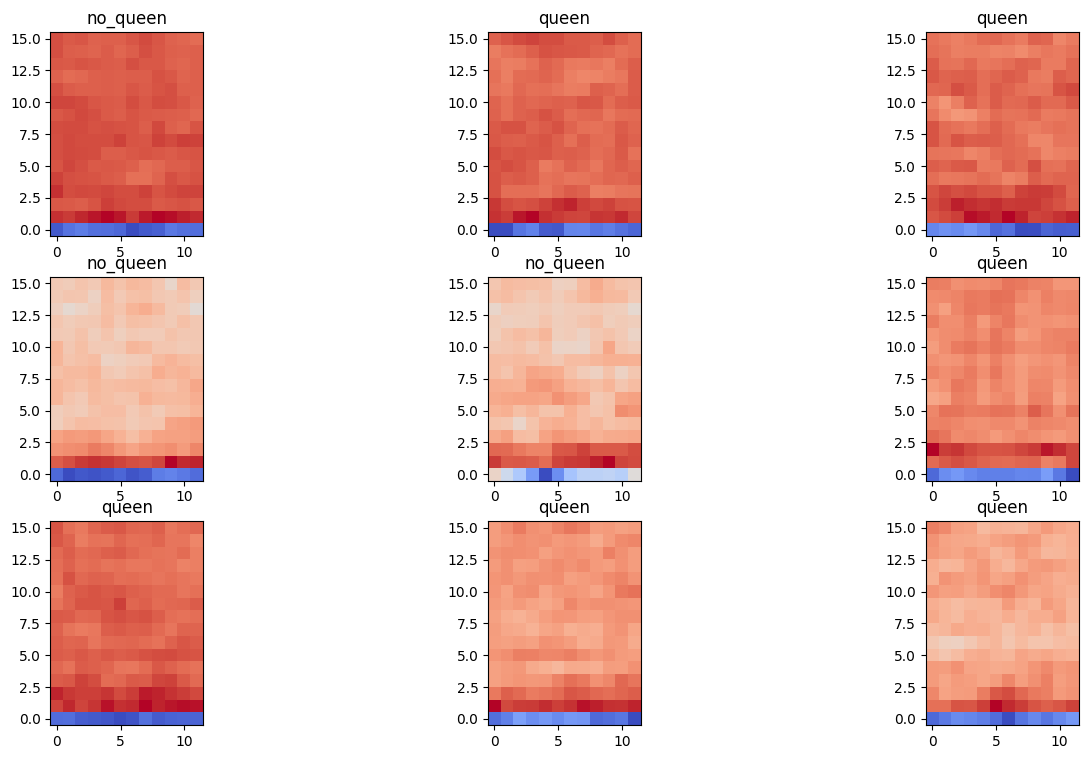

In [4]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 16, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

# Sequential model

In [7]:
model_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

2024-03-22 22:46:01.801337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [10]:
history = model_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
22/22 [==============================] - 0s 12ms/step - loss: 0.0555 - accuracy: 0.9869 - val_loss: 0.2506 - val_accuracy: 0.9357
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0397 - accuracy: 0.9854 - val_loss: 0.3001 - val_accuracy: 0.9298
Epoch 3/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0487 - accuracy: 0.9810 - val_loss: 0.3499 - val_accuracy: 0.9064
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0407 - accuracy: 0.9869 - val_loss: 0.4877 - val_accuracy: 0.9064
Epoch 5/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0628 - accuracy: 0.9810 - val_loss: 0.6411 - val_accuracy: 0.9006
Epoch 6/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0719 - accuracy: 0.9810 - val_loss: 0.3605 - val_accuracy: 0.9357
Epoch 7/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0076 - accuracy: 0.9971 - val_loss: 0.4429 - val_accuracy: 0.9357
Epoch 8/20
22

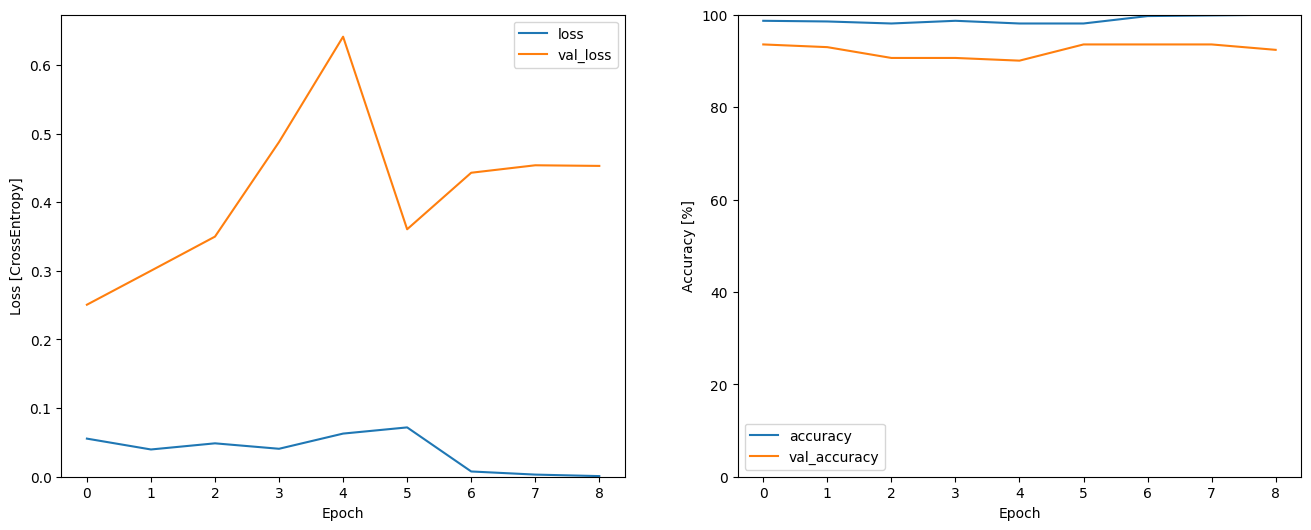

In [11]:
plot_history(history)

# Convolutional

In [12]:
model_conv = get_conv_model_mini(input_shape, len(label_names))
model_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [13]:
history = model_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


22/22 [==============================] - 2s 39ms/step - loss: 0.6125 - accuracy: 0.6657 - val_loss: 0.5088 - val_accuracy: 0.7193
Epoch 2/50
22/22 [==============================] - 0s 5ms/step - loss: 0.4421 - accuracy: 0.8248 - val_loss: 0.3815 - val_accuracy: 0.8480
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 0.3577 - accuracy: 0.8599 - val_loss: 0.2909 - val_accuracy: 0.9123
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.3063 - accuracy: 0.9036 - val_loss: 0.2545 - val_accuracy: 0.9181
Epoch 5/50
22/22 [==============================] - 0s 5ms/step - loss: 0.2474 - accuracy: 0.9197 - val_loss: 0.2391 - val_accuracy: 0.9064
Epoch 6/50
22/22 [==============================] - 0s 5ms/step - loss: 0.2439 - accuracy: 0.9241 - val_loss: 0.2059 - val_accuracy: 0.9474
Epoch 7/50
22/22 [==============================] - 0s 5ms/step - loss: 0.2202 - accuracy: 0.9255 - val_loss: 0.2019 - val_accuracy: 0.9474
Epoch 8/50
22/22 [============

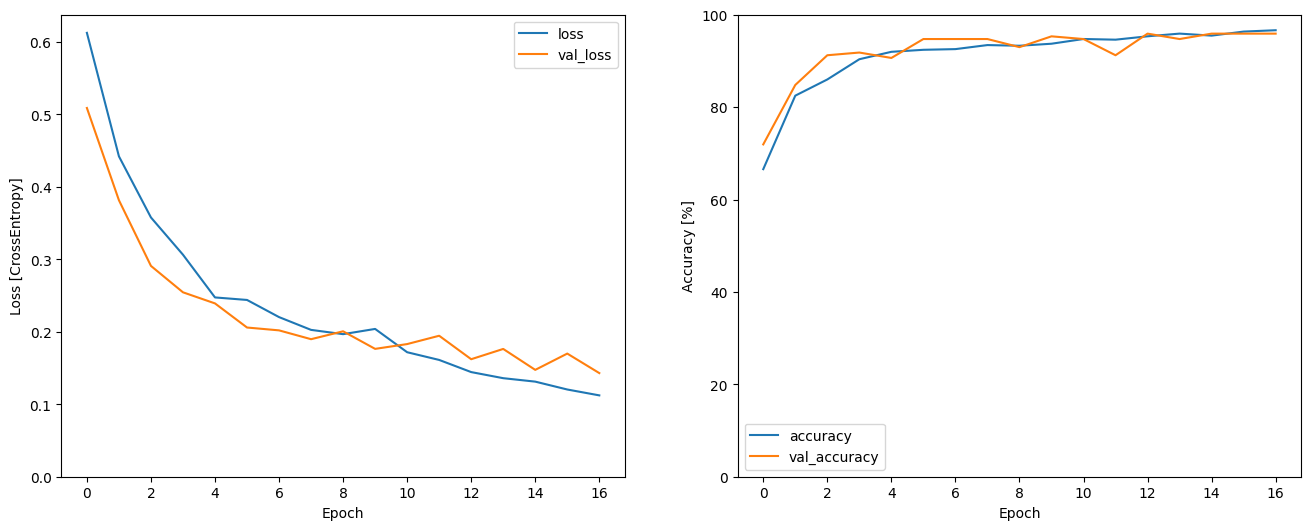

In [14]:
plot_history(history)

In [15]:
model_conv.save("osbh.h5")

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Validation

In [14]:
validation_ds = validation_tf("./dataset/osbh_pure_validation")
validation_ds = to_mfccs_dataset(validation_ds)
validation_ds = validation_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
validation_ds = validation_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)

Found 20 files belonging to 2 classes.
Using 1 files for training.
Using 19 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (2, 4000)
Example label shape: (2,)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100


In [15]:
model = tf.keras.models.load_model("osbh.h5")
results = model.evaluate(validation_ds)
print("Loss:", results[0])
print("Accuracy:", results[1])
results


10/10 [==============================] - 1s 68ms/step - loss: 0.2909 - accuracy: 0.8947
Loss: 0.29093536734580994
Accuracy: 0.8947368264198303


[0.29093536734580994, 0.8947368264198303]

In [17]:
accuracy_list = []
for example_spectrograms, example_spect_labels in validation_ds:
    print(example_spect_labels)
    accuracy = model.evaluate(example_spectrograms, example_spect_labels)
    accuracy_list.append(accuracy)
accuracy_list

tf.Tensor([1 0], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 39ms/step - loss: 0.1932 - accuracy: 1.0000
tf.Tensor([1], shape=(1,), dtype=int32)
1/1 [==============================] - 0s 22ms/step - loss: 0.0020 - accuracy: 1.0000
tf.Tensor([0 1], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 20ms/step - loss: 0.1627 - accuracy: 1.0000
tf.Tensor([0 1], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 18ms/step - loss: 0.0087 - accuracy: 1.0000
tf.Tensor([0 1], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 17ms/step - loss: 0.0382 - accuracy: 1.0000
tf.Tensor([0 1], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 18ms/step - loss: 0.2247 - accuracy: 1.0000
tf.Tensor([1 0], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 18ms/step - loss: 0.2015 - accuracy: 1.0000
tf.Tensor([0 0], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 17ms/step - loss: 0.85

[[0.19316326081752777, 1.0],
 [0.001966329989954829, 1.0],
 [0.16267095506191254, 1.0],
 [0.008742124773561954, 1.0],
 [0.03820265084505081, 1.0],
 [0.22474057972431183, 1.0],
 [0.2015039622783661, 1.0],
 [0.854266881942749, 0.5],
 [1.0707379579544067, 0.5],
 [0.008874338120222092, 1.0]]